<a href="https://colab.research.google.com/github/bitanb1999/NLP_Univ_Project/blob/main/Abstractive_Summarisation_using_SimpleRNN(Baseline).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstractive Summarisation using Baseline SimpleRNN model:


### **What is RNN?**
Recurrent Neural Network(RNN) are a type of Neural Network where the output from previous step are fed as input to the current step. In traditional neural networks, all the inputs and outputs are independent of each other, but in cases like when it is required to predict the next word of a sentence, the previous words are required and hence there is a need to remember the previous words. Thus RNN came into existence, which solved this issue with the help of a Hidden Layer. The main and most important feature of RNN is Hidden state, which remembers some information about a sequence.

### **How do we plan to use simpleRNN?**

The architechture involves using a simpleRNN tensorflow layers on the embeddings and obtaining the predictions, which would try to attain a decent summarisation. Given it is a baseline, we outperform this model with all the other models we experiment with.

#### Requirements:

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import re
import pickle

### Dataset:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df_all=pd.read_csv("/content/drive/MyDrive/AI3_project/df_all.csv")

In [ ]:
df_all=df_all[:1001]

In [ ]:
df=df_all.drop(["Unnamed: 0","title"],axis=1)
df.head()

,headline,text
0,"\nKeep related supplies in the same area.,\nMa...","If you're a photographer, keep all the necess..."
1,\nCreate a sketch in the NeoPopRealist manner ...,See the image for how this drawing develops s...
2,"\nGet a bachelor’s degree.,\nEnroll in a studi...",It is possible to become a VFX artist without...
3,\nStart with some experience or interest in ar...,The best art investors do their research on t...
4,"\nKeep your reference materials, sketches, art...","As you start planning for a project or work, ..."


In [ ]:
#clean data using helper code
import re
def transform(summary):
    # Lower case
    summary = summary.lower()
    summary=summary.replace('\n',' ')
    # Remove HTML
    summary = re.sub('<br /><br />', ' ', summary)
    
    # Replace all non-alphanumeric characters with spaces
    summary = re.sub(r'[^a-zA-Z0-9\s]', '', summary)
    
    return summary

In [ ]:
df['headline']=df['headline'].apply(lambda x:transform(str(x)))
df['text']=df['text'].apply(lambda x:transform(str(x)))


In [ ]:
df['headline']=df['headline'].apply(lambda x: 'sostok '+str(x)+' eostok')
df['text']=df['text'].apply(lambda x: 'sostok '+str(x)+' eostok')

In [ ]:
df.head()

,headline,text
0,sostok keep related supplies in the same area...,sostok if youre a photographer keep all the n...
1,sostok create a sketch in the neopoprealist m...,sostok see the image for how this drawing dev...
2,sostok get a bachelors degree enroll in a stu...,sostok it is possible to become a vfx artist ...
3,sostok start with some experience or interest...,sostok the best art investors do their resear...
4,sostok keep your reference materials sketches...,sostok as you start planning for a project or...


In [ ]:
import numpy as np  
import pandas as pd 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(df['text'],df['headline'],test_size=0.2,random_state=1,shuffle=True)

### Tokenisation:

In [ ]:
#tokenisation
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
x_tokenizer=tf.keras.preprocessing.text.Tokenizer(
    num_words=5000,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=True,
)
x_tokenizer.fit_on_texts(x_tr)

In [ ]:
#Find the percentage of occurrence of rare words (say, occurring less than 5 times) in the text.
thresh = 5

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

% of rare words in vocabulary:  70.69465009978755


In [ ]:
max_length=500
max_len_headlines=150

In [ ]:
# Prepare a tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words = 5000) 
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences to integer sequences 
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = tf.keras.preprocessing.sequence.pad_sequences(x_tr_seq,  maxlen=max_length, padding='post')
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val_seq, maxlen=max_length, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 5001


In [ ]:
# Prepare a tokenizer on testing data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh = 5

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=5000) 
y_tokenizer.fit_on_texts(list(y_tr))

# Convert text sequences to integer sequences 
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

# Pad zero upto maximum length
y_tr = tf.keras.preprocessing.sequence.pad_sequences(y_tr_seq, maxlen=max_length, padding='post')
y_val = tf.keras.preprocessing.sequence.pad_sequences(y_val_seq, maxlen=max_length, padding='post')

# Size of vocabulary (+1 for padding token)
y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

% of rare words in vocabulary: 76.43020594965675
Size of vocabulary in Y = 5001


In [ ]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []

for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

In [ ]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

In [ ]:

def get_dataset(token_text, token_headline):
	# Get a list of all tokens
	tokens_ = [j for i in token_text for j in i]

	# Find the number of tokens
	N_words_text = len(set(tokens_))

	target_headline = [i[1:] for i in token_headline]
	token_headline = [i[:-1] for i in token_headline]

	# Create a ragged tensor from the token lists
	ragged_text = tf.ragged.constant(token_text)
	ragged_headline = tf.ragged.constant(token_headline)
	ragged_target = tf.ragged.constant(target_headline)

	# Use from_tensor_slices to create tf dataset. The dataset will be of the form - ((input_text, input_headline), target_headline)
	dataset = tf.data.Dataset.from_tensor_slices((ragged_text, ragged_headline, ragged_target))
	dataset = dataset.shuffle(500)

	# Set the size of the batch
	dataset = dataset.batch(128)
	dataset = dataset.map(lambda x,y,z: ((x.to_tensor(default_value=0, shape=[None, None]), y.to_tensor(default_value=0, shape=[None, None])), z.to_tensor(default_value=0, shape=[None, None])) , num_parallel_calls=5)
	dataset = dataset.prefetch(1)

	return dataset





In [ ]:
token_text = x_tokenizer.texts_to_sequences(df["text"])
token_headline=y_tokenizer.texts_to_sequences(df["headline"])
tfdataset=get_dataset(token_text,token_headline)

### Modeling:

In [ ]:

vocab_size = 5000

inputs_text = tf.keras.Input(shape=tfdataset.element_spec[0][0].shape[1:])

# Set the input size to the decoder.
inputs_headline = tf.keras.Input(shape=tfdataset.element_spec[0][1].shape[1:])

# Specifying the size of embedding 
text_dim = 300
headline_dim = text_dim

hid_text = 30

emb_text = tf.keras.layers.Embedding(input_dim=vocab_size, 
                                    output_dim = text_dim, 
                                    mask_zero=True)(inputs_text)

RNN_text = tf.keras.layers.SimpleRNN(hid_text, activation='tanh', dropout=0.4,recurrent_dropout=0.4,return_sequences=False)
state_text = RNN_text(emb_text)


In [ ]:
# Set the size of the hidden state of the decoder as 10
hid_headline = 30
# Embedding layer for the decoder
emb_headline = tf.keras.layers.Embedding(input_dim=vocab_size+1, 
                                    output_dim = headline_dim, 
                                    mask_zero=True)(inputs_headline)

RNN_headline = tf.keras.layers.SimpleRNN(hid_headline, activation='tanh', dropout=0.4,recurrent_dropout=0.4,return_sequences=True)
states_headline = RNN_headline(emb_headline, initial_state=state_text)

In [ ]:

layer_output_headline = tf.keras.layers.Dense(vocab_size+1,activation='softmax')

# Get the output of the output layer of the decoder given the
# state of the decoder as input, y^
output_headline = layer_output_headline(states_headline)

In [ ]:
# Form the seq2seq model with the encoder and decoder

model = tf.keras.Model(inputs=(inputs_text, inputs_headline), outputs=output_headline)
optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss=tf.keras.losses.sparse_categorical_crossentropy)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 300)    1500000     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 300)    1500300     ['input_2[0][0]']                
                                                                                              

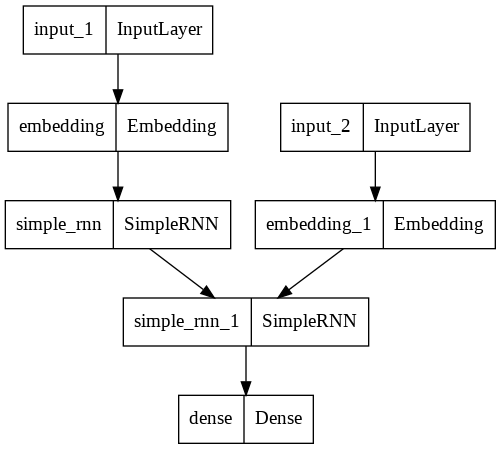

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

In [ ]:
tf.data.experimental.save(tfdataset, '/content/drive/MyDrive/AI3_project/tfdataset/')
# 

In [ ]:
tfdataset = tf.data.experimental.load('/content/drive/MyDrive/AI3_project/tfdataset/')

### Training:

In [ ]:
history=model.fit(tfdataset, epochs=5,verbose=1)

Epoch 1/5
8/8 [==============================] - 93s 11s/step - loss: 1.5886
Epoch 2/5
8/8 [==============================] - 66s 8s/step - loss: 1.7520
Epoch 3/5
8/8 [==============================] - 76s 10s/step - loss: 1.5709
Epoch 4/5
8/8 [==============================] - 69s 9s/step - loss: 1.6173
Epoch 5/5
8/8 [==============================] - 71s 9s/step - loss: 1.6473


### Inference:

In [ ]:
X=[]
Y=[]
for sample in tfdataset.take(10):
  in_ = sample[0][:2]
  res = model.predict(in_)[0]
  st = ""

  print(f'Training Text: \t\t {st.join(x_tokenizer.sequences_to_texts(in_[0].numpy()[:1]))}')
  print(f'True Summary:\t {st.join(y_tokenizer.sequences_to_texts([in_[1].numpy()[0]]))}')
  x=[y_tokenizer.sequences_to_texts([in_[1].numpy()[0]])]
  print(f'Predicted Summary:\t\t {st.join(x_tokenizer.sequences_to_texts([res.argmax(axis=1)]))}')
  y=[x_tokenizer.sequences_to_texts([res.argmax(axis=1)])]
  X.append(x)
  Y.append(y)

Training Text: 		 sostok it can be any color and any type as long as it could not potentially harm your guinea pig set it in the area you will be training in be sure to turn it so that your guinea pig will not knock it over as you begin to teach the trick a garbage can that may have anything that could be harmful should not be used gently lift them out of their cage and set them down near the garbage object allow the guinea pig to sniff around if they feel the need some may ignore it but this does not mean that they wont do the patience hold out one of the treats and your guinea pig towards the garbage can move it slightly further away and around it until your guinea pig has completed a of the circle click and treat do this three or four times until your guinea pig becomes comfortable with moving around it a bit every time the guinea pig moves forward a few steps reward them with a verbal marker and a treat gradually increase the amount of steps they take before receiving the treat hop

### Metrics:

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
scores=0
for i in range(len(X)):
    reference = [X[i][0][0].split(" ")]
    candidate = Y[i][0][0].split(" ")
    scores+= sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
print(scores/i)

0.041381927511269116


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

In [ ]:
!pip install rouge-score
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=864ff4c4c36afd8b7676e88d39cb11f2f4b02647b3b58461343b3a1c0429d7df
  Stored in directory: /root/.cache/pip/wheels/84/ac/6b/38096e3c5bf1dc87911e3585875e21a3ac610348e740409c76
Successfully built rouge-score


In [ ]:
X[0][0][0]

'sostok get a small garbage can or round cylindershaped object of some sort place your guinea pig in the general area use a treat to lure your guinea pig to it stand back and see if the guinea pig will try to go around on its own eventually begin only treating your guinea pig when they make a full circle around the object begin enforcing a hand motion take the garbage can away gradually'

In [ ]:

scores=[]
for i in range(len(X)):
    reference = Y[i][0][0]
    candidate = X[i][0][0]
    d=scorer.score(reference,candidate)['rouge1']
    print(d)
    scores.append(d[2])


Score(precision=0.20270270270270271, recall=0.06465517241379311, fmeasure=0.09803921568627451)
Score(precision=0.21428571428571427, recall=0.032846715328467155, fmeasure=0.0569620253164557)
Score(precision=0.078125, recall=0.013404825737265416, fmeasure=0.022883295194508012)
Score(precision=0.15384615384615385, recall=0.014367816091954023, fmeasure=0.026281208935611037)
Score(precision=0.22727272727272727, recall=0.0411522633744856, fmeasure=0.06968641114982578)
Score(precision=0.18181818181818182, recall=0.015345268542199489, fmeasure=0.028301886792452834)
Score(precision=0.22972972972972974, recall=0.1069182389937107, fmeasure=0.1459227467811159)
Score(precision=0.1, recall=0.019851116625310174, fmeasure=0.033126293995859216)


In [ ]:
np.mean([i for i in scores])

0.06015038548151287